In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize
from pathlib import Path
import pandas as pd
from scipy import stats

In [2]:
def read_alchem_analysis_results(res_txt_file):
    """
    read the output "results.txt" from alchemical_analysis.py
    return all the estimates in a dictionary
    """
    with open(res_txt_file) as f:
        lines = f.readlines()
    for l in lines:
        if "States" in l:
            res_dict = {}
            method_list = []
            for word in l.split()[1::2]:
                method_list.append(word)
    l = lines[-1]
    words = l.split()
    res_dict = {}
    for method, fE, err in zip(method_list, words[1::3], words[3::3]):
        res_dict[method] = (float(fE), float(err))
    return res_dict



In [3]:
def read_pmx_freeE(res_txt):
    """
    read a pmx analyse output (results.txt)
    return the free energy in kcal
    """
    with open(res_txt) as f:
        lines = f.readlines()
    for l in lines:
        if "BAR: dG" in l:
            words = l.split()
            if words[4] == "kJ/mol":
                kcal = float(words[3]) * 0.239006
            elif words[4] == "kCal/mol":
                kcal = float(words[3])
            return kcal


# ASP + GLUP -> ASPP + GLU
$ASP^{-1} + GLU-H = ASP-H + GLU^{-1}$

In [11]:
delta_G = [read_alchem_analysis_results(Path("../") / f"ASP-GLU/03-HRE/run_{i}" / "02-win16/results/results.txt")["MBAR"][0] for i in range(1,6)]
print(f"delta G = {np.mean(delta_G):.2f} ± {stats.sem(delta_G):.2f}")


delta G = -24.19 ± 0.03


In [9]:
base = Path("../")

freeE_pmx = {}
freeE_hre = {}

suf_pmx = "results.txt" # PMX
suf_hre = "02-win16/results/results.txt" 

for res1 in ["ASP","GLU","CYM","HSD","HSE","LSN"]:
    for res2 in ["ASP","GLU","CYM","HSD","HSE","LSN"]:
        if res1 != res2 :
            # PMX no-eq-TI
            freeE_pmx[f"{res1}-{res2}"] = np.array([read_pmx_freeE(base / f"{res1}-{res2}/02-PMX/run_{i}" / suf_pmx)                          for i in range(1,6)])
            freeE_hre[f"{res1}-{res2}"] = np.array([read_alchem_analysis_results(base / f"{res1}-{res2}/03-HRE/run_{i}" / suf_hre)["MBAR"][0] for i in range(1,6)])


In [10]:
# object function for fitting (optimization)
def func(vec):
    dg_pro = {
    "ASP":vec[0],
    "GLU":vec[1],
    "CYM":vec[2],
    "HSD":vec[3],
    "HSE":vec[4],
    "LSN":vec[5],}
    error = 0
    for res1 in ["ASP","GLU","CYM","HSD","HSE","LSN"]:
        for res2 in ["ASP","GLU","CYM","HSD","HSE","LSN"]:
            if res1 != res2 :
                dg = dg_pro[res1] - dg_pro[res2]
                e_tmp = np.sum(np.abs(np.mean(free_E_dict[f"{res1}-{res2}"]) - dg))
                # e_tmp = np.sum(np.abs(free_E_dict[f"{res1}-{res2}"] - dg))
                error += e_tmp
    # error += np.sum(vec)*1000
    return error

In [12]:
def print_res(res):
    # print(f"                       ASP    GLU    CYS    LYS    HSD   HSE  Error")
    print(f"{res.x[0]:6.2f} {res.x[1]:6.2f} {res.x[2]:6.2f} {res.x[5]:6.2f} {res.x[3]:6.2f}{res.x[4]:6.2f} {res.fun/30:6.2f}")

print(f"                   ASP    GLU    CYS    LYS    HSD   HSE   Error(AUE)")
# PMX
free_E_dict = freeE_pmx
res = minimize(func, [0,0,0,0,0,0])
print("PMX (kcal/mol): ", end = "")
print_res(res)

# HRE
free_E_dict = freeE_hre
res = minimize(func, [0,0,0,0,0,0])
print("HRE (kcal/mol): ", end = "")
print_res(res)

                   ASP    GLU    CYS    LYS    HSD   HSE   Error(AUE)
PMX (kcal/mol):  12.80  36.46  56.86 -70.74 -26.20 -9.18   0.21
HRE (kcal/mol):  12.60  36.74  56.58 -70.84 -25.91 -9.17   0.12


In [13]:
std_pmx = []
std_hre = []
print("Pair    pmx  hre  pmx/hre")
for pair, freeE in freeE_pmx.items():
    # print(pair, np.std(freeE))
    e_hre = freeE_hre[pair]
    std_pmx.append(np.std(freeE))
    std_hre.append(np.std(e_hre))
    print(f"{pair} {np.std(freeE):4.2f} {np.std(e_hre):4.2f} {np.std(freeE)/np.std(e_hre):5.2f}")

Pair    pmx  hre  pmx/hre
ASP-GLU 0.51 0.06  8.16
ASP-CYM 0.21 0.19  1.09
ASP-HSD 0.59 0.22  2.68
ASP-HSE 0.54 0.12  4.52
ASP-LSN 0.24 0.16  1.55
GLU-ASP 0.51 0.41  1.25
GLU-CYM 0.46 0.34  1.37
GLU-HSD 1.02 0.28  3.68
GLU-HSE 0.40 0.19  2.15
GLU-LSN 0.18 0.16  1.18
CYM-ASP 0.22 0.13  1.66
CYM-GLU 0.78 0.28  2.74
CYM-HSD 0.50 0.23  2.19
CYM-HSE 0.39 0.12  3.38
CYM-LSN 0.11 0.08  1.39
HSD-ASP 0.63 0.26  2.38
HSD-GLU 0.43 0.30  1.41
HSD-CYM 0.62 0.22  2.79
HSD-HSE 0.69 0.33  2.11
HSD-LSN 0.35 0.25  1.38
HSE-ASP 0.56 0.09  6.33
HSE-GLU 0.20 0.15  1.33
HSE-CYM 0.73 0.06 13.13
HSE-HSD 0.41 0.34  1.21
HSE-LSN 0.67 0.37  1.80
LSN-ASP 0.33 0.12  2.72
LSN-GLU 0.55 0.11  5.05
LSN-CYM 0.11 0.07  1.55
LSN-HSD 0.43 0.27  1.59
LSN-HSE 0.64 0.18  3.55


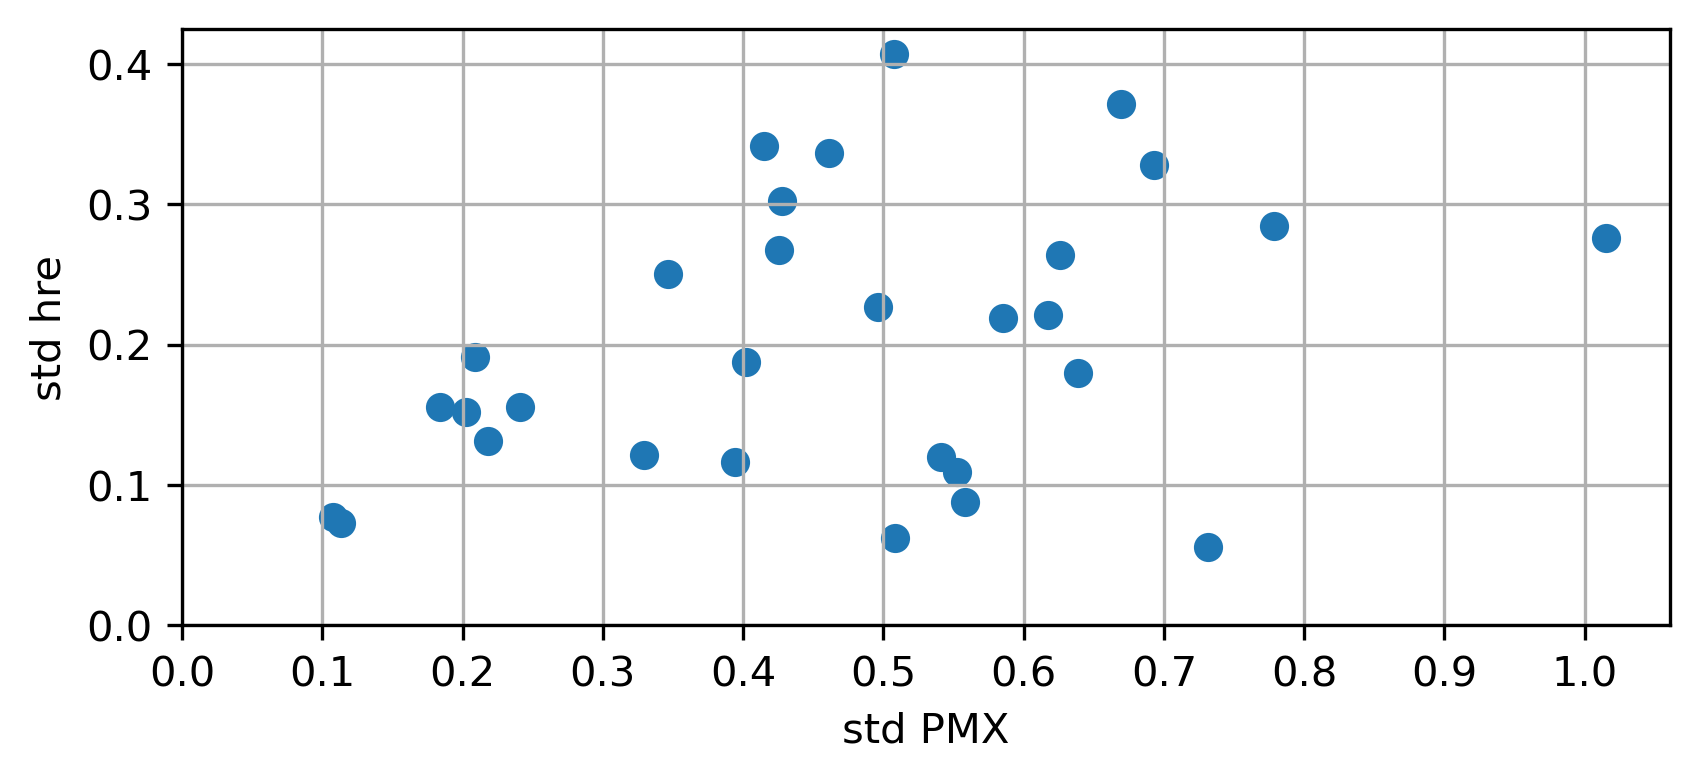

In [14]:
fig, ax = plt.subplots(1,1,dpi=300)
ax.scatter(std_pmx, std_hre)
ax.set_ylabel("std hre")
ax.set_xlabel("std PMX")
ax.set_xticks(np.arange(0, 1.01, 0.1))
ax.set_yticks(np.arange(0, 0.41, 0.1))

ax.grid()
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect of plot to be equal
plt.savefig("std_compare.png", bbox_inches='tight')

In [22]:
speed = (65.80000)/1000 / ((8*60 + 0) / 60/60) # ns/h
speed

0.4935

In [28]:
(80 - 77.1) / speed 


5.876393110435675